In [2]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import kstest
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import cohen_kappa_score
import imblearn
from sklearn.metrics import balanced_accuracy_score
from imblearn.pipeline import make_pipeline
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import datasets


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold




red_wines = pd.read_csv("winequality-red.csv", sep = ";")
white_wines = pd.read_csv("winequality-white.csv", sep =";")

In [3]:
# formatting
red_wines.columns= red_wines.columns.str.replace(' ','_')
white_wines.columns = white_wines.columns.str.replace(' ','_')

#Quality categories
red_wines ['quality_label'] = red_wines['quality'].apply(lambda value: 'low' if value <= 5 
                                                        else 'medium' if value <= 7 
                                                        else 'high')

red_wines['quality_label'] = pd.Categorical(red_wines['quality_label'],
categories=['low', 'medium', 'high'])

white_wines ['quality_label'] = white_wines['quality'].apply(lambda value: 'low' if value <= 5 
                                                        else 'medium' if value <= 7 
                                                        else 'high')

white_wines["quality_label"] = pd.Categorical(white_wines["quality_label"], categories = ["low","medium","high"])

# Type of wine categories
red_wines ["type"] = 'Red Wine'
red_wines['type'] = pd.Categorical(red_wines['type'],
categories=["Red Wine","White Wine"])

white_wines ["type"] = 'White Wine'
white_wines['type'] = pd.Categorical(white_wines['type'],
categories=["Red Wine","White Wine"])

# merge datasets
white_and_red = pd.merge(red_wines, white_wines, how = "outer")

#make copy
white_and_red_ml= white_and_red.copy()

In [4]:
white_and_red_ml["quality_label"].head(10)

0    medium
1      high
2    medium
3       low
4      high
5    medium
6    medium
7       low
8       low
9       low
Name: quality_label, dtype: category
Categories (3, object): ['low', 'medium', 'high']

# Filtering outliers

In [5]:
white_wines_clean= white_wines.drop("quality", axis=1)
numeric_columns_white = white_wines_clean.select_dtypes(include=['float64', 'int64'])

white_wine_filtered= white_wines.copy()
for column in numeric_columns_white.columns:
        q1 = np.quantile(numeric_columns_white[column], 0.25)
        q3 = np.quantile(numeric_columns_white[column], 0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Filter rows based on the column's outlier range
        white_wine_filtered = white_wine_filtered[(white_wine_filtered[column] >= lower) & (white_wine_filtered[column] <= upper)]
print("white wine shape; ", white_wines.shape, "\nfiltered white wine shape: ", white_wine_filtered.shape)


white wine shape;  (4898, 14) 
filtered white wine shape:  (4015, 14)


In [6]:
red_wines_clean= red_wines.drop("quality", axis=1)
numeric_columns_red = red_wines_clean.select_dtypes(include=['float64', 'int64'])

red_wine_filtered= red_wines.copy()
for column in numeric_columns_red.columns: 
        q1 = np.quantile(numeric_columns_red[column], 0.25)
        q3 = np.quantile(numeric_columns_red[column], 0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Filter rows based on the column's outlier range
        red_wine_filtered = red_wine_filtered[(red_wine_filtered[column] >= lower) & (red_wine_filtered[column] <= upper)]
print("red wine shape; ", red_wines.shape, "\nfiltered red wine shape: ", red_wine_filtered.shape)

red wine shape;  (1599, 14) 
filtered red wine shape:  (1194, 14)


# Encoding

In [7]:
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
white_and_red_ml['quality_label_encoded'] = enc.fit_transform(white_and_red_ml[['quality_label']])
white_and_red_ml["quality_label"].head()



0    medium
1      high
2    medium
3       low
4      high
Name: quality_label, dtype: category
Categories (3, object): ['low', 'medium', 'high']

In [8]:
# le = LabelEncoder()
# white_and_red_ml['quality_label'] = le.fit_transform(white_and_red_ml['quality_label'])
# white_and_red_ml["quality_label"].head()



In [9]:
white_and_red_ml.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,quality_label,type,quality_label_encoded
0,3.8,0.310,0.02,11.1,0.036,20.0,114.0,0.99248,3.75,0.44,12.4,6,medium,White Wine,1.0
1,3.9,0.225,0.40,4.2,0.030,29.0,118.0,0.98900,3.57,0.36,12.8,8,high,White Wine,2.0
2,4.2,0.170,0.36,1.8,0.029,93.0,161.0,0.98999,3.65,0.89,12.0,7,medium,White Wine,1.0
3,4.2,0.215,0.23,5.1,0.041,64.0,157.0,0.99688,3.42,0.44,8.0,3,low,White Wine,0.0
4,4.4,0.320,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,8,high,White Wine,2.0


In [10]:
# split data

X=white_and_red_ml.drop(["type","quality_label","quality","quality_label_encoded"], axis=1)
y= white_and_red_ml["quality_label_encoded"]

print("original:", white_and_red_ml.shape, "\nX:", X.shape, "\ny:", y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
y_test.shape

original: (6497, 15) 
X: (6497, 11) 
y: (6497,)


(1300,)

# Normalization

In [11]:
# Standarization and normalization

norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing data
X_test_norm = norm.transform(X_test)

# Logistic Regression

In [12]:
## logistic regression
LR_model = LogisticRegression(max_iter=700)
LR_model.fit(X_train_norm, y_train)
preds = LR_model.predict(X_test_norm)

## Accuracy
acc = accuracy_score(y_test, preds)
print(acc)
LR_model

0.7038461538461539


LogisticRegression(max_iter=700)

In [13]:
# merge datasets
white_and_red_filtered = pd.merge(red_wine_filtered, white_wine_filtered, how = "outer")

# Encoding
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])
white_and_red_filtered['quality_label_encoded'] = enc.fit_transform(white_and_red_filtered[['quality_label']])


from sklearn.model_selection import train_test_split
X2=white_and_red_filtered.drop(["type","quality_label","quality","quality_label_encoded"], axis=1)
y2= white_and_red_filtered["quality_label_encoded"]

print("original:", white_and_red_filtered .shape, "\nX:", X2.shape, "\ny:", y2.shape)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=42)
## standarization
norm = MinMaxScaler().fit(X2_train)

# transform training data
X2_train_norm = norm.transform(X2_train)

# transform testing data
X2_test_norm = norm.transform(X2_test)
## logistic regression
LR_model2 = LogisticRegression(max_iter=700)
LR_model2.fit(X2_train_norm, y2_train)
preds2 = LR_model2.predict(X2_test_norm)

## Accuracy
acc2 = accuracy_score(y2_test, preds2)

print(f"logistic regression accuracy: {acc2:.4f}")
kappa_lr = cohen_kappa_score(preds2, y2_test)
print(f"Cohen-Kappa score: {kappa_lr:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, preds2):.4f}")


original: (5209, 15) 
X: (5209, 11) 
y: (5209,)
logistic regression accuracy: 0.7092
Cohen-Kappa score: 0.3259
The balanced accuracy score is 0.4452


# Random forest

## Model 1

In [14]:
#NO filters
# # define model
RF_clf = RandomForestClassifier(random_state=42)
# fit model
RF_clf.fit(X_train_norm, y_train)
# make predictions
RF_preds = RF_clf.predict(X_test_norm)

RF_acc = accuracy_score(y_test, RF_preds)
print( f"Random Forest Accuracy score: {RF_acc:.4f}")
kappa = cohen_kappa_score(RF_preds, y_test)
print(f"Cohen-Kappa score: {kappa:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y_test, RF_preds):.4f}")

Random Forest Accuracy score: 0.7946
Cohen-Kappa score: 0.5753
The balanced accuracy score is 0.6053


In [15]:
# with filtered outliers
# define model
RF_clf = RandomForestClassifier(random_state=42)
# fit model
RF_clf.fit(X2_train_norm, y2_train)
# make predictions
RF_preds = RF_clf.predict(X2_test_norm)

RF_acc = accuracy_score(y2_test, RF_preds)
print( f"Random Forest Accuracy score: {RF_acc:.4f}")
kappa = cohen_kappa_score(RF_preds, y2_test)
print(f"Cohen-Kappa score: {kappa:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, RF_preds):.4f}")

Random Forest Accuracy score: 0.8157
Cohen-Kappa score: 0.5917
The balanced accuracy score is 0.6391


## Balancing the data set

### Model 2


In [16]:
# with balanced class_weight and unfiltered
# define model
RF2_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model
RF2_clf.fit(X_train_norm, y_train)
# make predictions
RF2_preds = RF2_clf.predict(X_test_norm)

RF2_acc = accuracy_score(y_test, RF2_preds)
print( f"Random Forest Accuracy score: {RF2_acc:.4f}")
kappa = cohen_kappa_score(RF2_preds, y_test)
print(f"Cohen-Kappa score: {kappa:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y_test, RF2_preds):.4f}")

Random Forest Accuracy score: 0.8000
Cohen-Kappa score: 0.5811
The balanced accuracy score is 0.5996


In [17]:
# with balanced class_weight and filtered
# define model
RF2_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model
RF2_clf.fit(X2_train_norm, y2_train)
# make predictions
RF2_preds = RF2_clf.predict(X2_test_norm)

RF2_acc = accuracy_score(y2_test, RF2_preds)
print( f"Random Forest Accuracy score: {RF2_acc:.4f}")
kappa = cohen_kappa_score(RF2_preds, y2_test)
print(f"Cohen-Kappa score: {kappa:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, RF2_preds):.4f}")

Random Forest Accuracy score: 0.8129
Cohen-Kappa score: 0.5839
The balanced accuracy score is 0.6355


In [18]:
labels = np.unique(y2_test)
a = confusion_matrix(y2_test, RF2_preds, labels=labels)
a = pd.DataFrame(a)
display(a)

,0,1,2
0,225,105,0
1,66,611,1
2,0,23,11


### Model 3
RF with SMOTE & balanced class weight

In [19]:
#REVIEW - Check  doing the smote resampling after train-test split
# unfiltered
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
print(pd.Series(y_resampled).value_counts())

# Train-test split
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

## standarization
norm = MinMaxScaler().fit(X_train_smote)

# transform training data
X_train_smote_norm = norm.transform(X_train_smote)

# transform testing data
X_test_smote_norm = norm.transform(X_test_smote)
# define model
RF = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model
RF.fit(X_train_smote_norm, y_train_smote)
# make predictions
RF_pred = RF_clf.predict(X_test_smote_norm)

RF_acc = accuracy_score(y_test_smote, RF_pred)
print( f"Random Forest Accuracy score: {RF_acc:.4f}")
kappa = cohen_kappa_score(RF_pred, y_test_smote)
print(f"Cohen-Kappa score: {kappa:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y_test_smote, RF_pred):.4f}")

quality_label_encoded
1.0    3915
2.0    3915
0.0    3915
Name: count, dtype: int64
Random Forest Accuracy score: 0.4227
Cohen-Kappa score: 0.1341
The balanced accuracy score is 0.4227


In [20]:
#RF with SMOTE & balanced class weight / filtered
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X2, y2)

# Check new class distribution
print(pd.Series(y_resampled).value_counts())

# Train-test split
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

## standarization
norm = MinMaxScaler().fit(X_train_smote)

# transform training data
X_train_smote_norm = norm.transform(X_train_smote)

# transform testing data
X_test_smote_norm = norm.transform(X_test_smote)
# define model
RF = RandomForestClassifier(random_state=42, class_weight="balanced")
# fit model
RF.fit(X_train_smote_norm, y_train_smote)
# make predictions
RF_pred = RF_clf.predict(X_test_smote_norm)

RF_acc = accuracy_score(y_test_smote, RF_pred)
print( f"Random Forest Accuracy score: {RF_acc:.4f}")
kappa = cohen_kappa_score(RF_pred, y_test_smote)
print(f"Cohen-Kappa score: {kappa:.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y_test_smote, RF_pred):.4f}")

quality_label_encoded
1.0    3296
2.0    3296
0.0    3296
Name: count, dtype: int64
Random Forest Accuracy score: 0.6916
Cohen-Kappa score: 0.5375
The balanced accuracy score is 0.6918


In [21]:
# RF With SMOTE in pipe line, no 
pipe = make_pipeline(imblearn.over_sampling.SMOTE(), 
                     RandomForestClassifier( class_weight="balanced", random_state=42))
pipe.fit(X2_train_norm, y2_train)
y2_pred = pipe.predict(X2_test_norm)
print(f"The accuracy score is {accuracy_score(y2_test, y2_pred):.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, y2_pred):.4f}")

The accuracy score is 0.7869
The balanced accuracy score is 0.6766


In [22]:
# LR with SMOTE
pipe2 = make_pipeline(imblearn.over_sampling.SMOTE(), 
                     LogisticRegression( class_weight="balanced", random_state=42))
pipe2.fit(X2_train_norm, y2_train)
y3_pred = pipe2.predict(X2_test_norm)
print(f"The accuracy score is {accuracy_score(y2_test, y3_pred):.4f}")
print(f"The balanced accuracy score is {balanced_accuracy_score(y2_test, y3_pred):.4f}")


The accuracy score is 0.4760
The balanced accuracy score is 0.5700


### Model 4 - RF/Srt K-fold x.val(no smote)

#### unfiltered

In [23]:


scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X)
# Create  classifier object.
# lr = linear_model.LogisticRegression()
rf = RandomForestClassifier(class_weight="balanced")

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
lst_kappa =[]
lst_balanced_accuracy_score =[]
  
for train_index, test_index in skf.split(X,y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    rf.fit(x_train_fold, y_train_fold)
    rf_pred = rf.predict(x_test_fold) 
    kappa = cohen_kappa_score(rf_pred, y_test_fold)
    lst_accu_stratified.append(rf.score(x_test_fold, y_test_fold))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold, rf_pred)
    lst_balanced_accuracy_score.append(f"{balanced_acc_sc:.4f}")
    lst_kappa.append(f"{kappa:.4f}")


  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print("\nList of possible Cohen-Kappa score:", lst_kappa)
print("\nList of possible balanced accuracy score:", lst_balanced_accuracy_score)

List of possible accuracy: [0.8061538461538461, 0.8138461538461539, 0.7923076923076923, 0.8323076923076923, 0.8061538461538461, 0.816923076923077, 0.8092307692307692, 0.8305084745762712, 0.8412942989214176, 0.8197226502311248]

Maximum Accuracy That can be obtained from this model is: 84.12942989214176 %

Minimum Accuracy: 79.23076923076923 %

Overall Accuracy: 81.6844850065189 %

Standard Deviation is: 0.014641991264298713

List of possible Cohen-Kappa score: ['0.6012', '0.6093', '0.5640', '0.6526', '0.5970', '0.6184', '0.6026', '0.6517', '0.6692', '0.6239']

List of possible balanced accuracy score: ['0.6384', '0.6219', '0.6061', '0.6905', '0.6550', '0.7156', '0.6202', '0.6863', '0.6890', '0.7027']


#### filtered REPEATED STRKFOLD

In [24]:

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X2)
# Create  classifier object.
# lr = linear_model.LogisticRegression()
rf = RandomForestClassifier(class_weight="balanced")

# Create StratifiedKFold object.
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
lst_accu_stratified = []
lst_kappa =[]
lst_balanced_accuracy_score =[]
  
for train_index, test_index in skf.split(X2,y2):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold_1 = y2[train_index], y2[test_index]
    rf.fit(x_train_fold, y_train_fold)
    rf_pred_1 = rf.predict(x_test_fold) 
    kappa = cohen_kappa_score(rf_pred_1, y_test_fold_1)
    lst_accu_stratified.append(rf.score(x_test_fold, y_test_fold_1))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold_1, rf_pred_1)
    lst_balanced_accuracy_score.append(f"{balanced_acc_sc:.4f}")
    lst_kappa.append(f"{kappa:.4f}")


# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print("\nList of possible Cohen-Kappa score:", lst_kappa)
print("\nList of possible balanced accuracy score:", lst_balanced_accuracy_score)

List of possible accuracy: [0.8426103646833013, 0.7927063339731286, 0.7984644913627639, 0.817658349328215, 0.8330134357005758, 0.817658349328215, 0.8119001919385797, 0.8023032629558541, 0.8253358925143954, 0.8211538461538461, 0.8119001919385797, 0.8330134357005758, 0.8272552783109405, 0.8099808061420346, 0.8119001919385797, 0.8253358925143954, 0.8138195777351248, 0.7965451055662188, 0.8157389635316699, 0.8115384615384615, 0.8234165067178503, 0.8157389635316699, 0.8253358925143954, 0.8138195777351248, 0.8310940499040307, 0.8272552783109405, 0.8272552783109405, 0.8080614203454894, 0.8119001919385797, 0.7884615384615384]

Maximum Accuracy That can be obtained from this model is: 84.26103646833013 %

Minimum Accuracy: 78.84615384615384 %

Overall Accuracy: 81.64057040208672 %

Standard Deviation is: 0.012606908768585539

List of possible Cohen-Kappa score: ['0.6640', '0.5457', '0.5595', '0.5933', '0.6327', '0.6044', '0.5970', '0.5676', '0.6217', '0.6134', '0.5884', '0.6336', '0.6307', '0.5

In [25]:
# Classification report
print("Classification Report:")
print(classification_report(y_test_fold_1, rf_pred_1))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.67      0.71       175
         1.0       0.81      0.88      0.84       329
         2.0       0.80      0.25      0.38        16

    accuracy                           0.79       520
   macro avg       0.79      0.60      0.64       520
weighted avg       0.79      0.79      0.78       520



In [26]:
from numpy import std
model = RandomForestClassifier(class_weight="balanced")
scores = cross_val_score(model, X2, y2, scoring='accuracy', cv=skf, n_jobs=-1)
print('Mean Accuracy: %.3f' % mean(scores))
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

from sklearn.metrics import recall_score
model.fit(x_train_fold, y_train_fold)
probabilities = model.predict_proba(x_test_fold)[:, 1]
threshold = 0.3
predictions = (probabilities >= threshold).astype(int)
recall = recall_score(y_test_fold_1, predictions, average="weighted")
print("Recall:", recall) 



Mean Accuracy: 0.818
Accuracy: 0.818 (0.014)
Recall: 0.7615384615384615


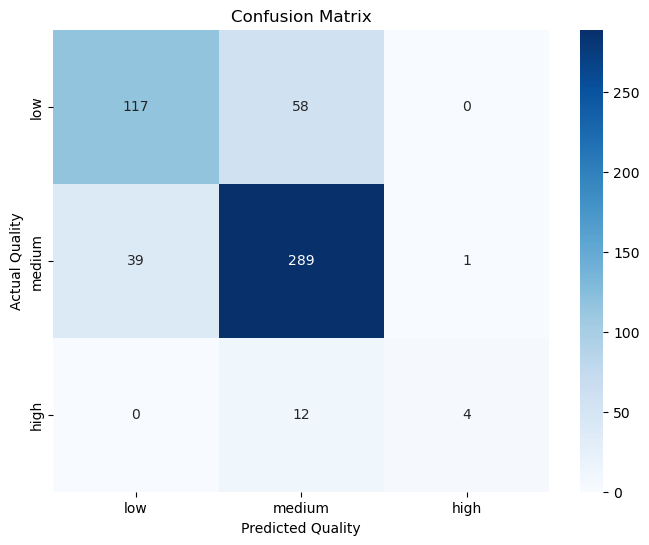

In [27]:
cm = confusion_matrix(y_test_fold_1, rf_pred_1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix')
plt.show()

### Model 5 - Random forest with SMOTE & Stratified K-fold cross validation

#### unfiltered 

In [28]:
smote = SMOTE(random_state=42)


scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X) # normalizes for all X, instead of dividing in train and test.scaling after smote

# Create  classifier object.

rf = RandomForestClassifier(class_weight="balanced")
  
# Create StratifiedKFold object.
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
lst_accu_stratified = []
lst_balanced_accuracy_score=[]
lst_kappa= []

# .split generates indices to split data into training and test set.
for train_index, test_index in skf.split(X,y):  
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train_fold, y_train_fold)
    rf.fit(x_train_resampled, y_train_resampled)
    rf_pred = rf.predict(x_test_fold)
    kappa = cohen_kappa_score(rf_pred, y_test_fold)
    lst_kappa.append(round(kappa, 4))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold, rf_pred)
    lst_balanced_accuracy_score.append(round(balanced_acc_sc,4))
    lst_accu_stratified.append(rf.score(x_test_fold, y_test_fold))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print('\nMaximum Cohen-Kappa score that can be obtained from this model is:',
      max(lst_kappa)*100, '%')
print('\nMaximum Balanced Accuracy That can be obtained from this model is:',
      max(lst_balanced_accuracy_score)*100, '%')

List of possible accuracy: [0.7892307692307692, 0.8107692307692308, 0.7815384615384615, 0.8138461538461539, 0.8, 0.8061538461538461, 0.8046153846153846, 0.8166409861325116, 0.8258859784283513, 0.802773497688752, 0.8061538461538461, 0.8338461538461538, 0.8184615384615385, 0.8015384615384615, 0.796923076923077, 0.8276923076923077, 0.7984615384615384, 0.8058551617873652, 0.8243451463790447, 0.7842835130970724, 0.7953846153846154, 0.8138461538461539, 0.8138461538461539, 0.8276923076923077, 0.8261538461538461, 0.8107692307692308, 0.7553846153846154, 0.8181818181818182, 0.7950693374422187, 0.8258859784283513]

Maximum Accuracy That can be obtained from this model is: 83.38461538461537 %

Minimum Accuracy: 75.53846153846155 %

Overall Accuracy: 80.77076369957726 %

Standard Deviation is: 0.016776978956063452

Maximum Cohen-Kappa score that can be obtained from this model is: 66.74 %

Maximum Balanced Accuracy That can be obtained from this model is: 76.14999999999999 %


#### filtered

In [29]:
#FIXME -  Cannot do the split for the resampled data, as the resampling should be done
# Apply SMOTE
# X2 = feature columns of white_and_red, filtered but not normalized

smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X2_train, y2_train)
# Scaling 
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X2)

# Classifier object
rf = RandomForestClassifier(class_weight="balanced")

# Create StratifiedKFold object.
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
lst_accu_stratified = []
lst_kappa =[]
lst_balanced_accuracy_score =[]
  
# .split generates indices to split data into training and test set.
for train_index, test_index in skf.split(X2,y2):  
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold_2 = y2[train_index], y2[test_index]
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train_fold, y_train_fold)
    rf.fit(x_train_resampled, y_train_resampled)
    rf_pred_2 = rf.predict(x_test_fold)
    kappa = cohen_kappa_score(rf_pred_2, y_test_fold_2)
    lst_kappa.append(round(kappa, 4))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold_2, rf_pred_2)
    lst_balanced_accuracy_score.append(round(balanced_acc_sc,4))
    lst_accu_stratified.append(rf.score(x_test_fold, y_test_fold_2))
  
# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))
print('\nMaximum Cohen-Kappa score that can be obtained from this model is:',
      max(lst_kappa)*100, '%')
print('\nMaximum Balanced Accuracy That can be obtained from this model is:',
      max(lst_balanced_accuracy_score)*100, '%')


List of possible accuracy: [0.8330134357005758, 0.7907869481765835, 0.7715930902111324, 0.8080614203454894, 0.8310940499040307, 0.8042226487523992, 0.783109404990403, 0.8061420345489443, 0.8138195777351248, 0.8153846153846154, 0.8253358925143954, 0.8349328214971209, 0.8099808061420346, 0.7984644913627639, 0.7965451055662188, 0.8138195777351248, 0.8061420345489443, 0.7696737044145874, 0.8023032629558541, 0.7903846153846154, 0.8195777351247601, 0.8099808061420346, 0.8234165067178503, 0.8234165067178503, 0.8138195777351248, 0.8042226487523992, 0.8138195777351248, 0.7907869481765835, 0.8234165067178503, 0.7634615384615384]

Maximum Accuracy That can be obtained from this model is: 83.49328214971209 %

Minimum Accuracy: 76.34615384615384 %

Overall Accuracy: 80.63575963384024 %

Standard Deviation is: 0.018325970303351268

Maximum Cohen-Kappa score that can be obtained from this model is: 65.93 %

Maximum Balanced Accuracy That can be obtained from this model is: 77.22 %


In [36]:
print("Classification Report:")
print(classification_report(y_test_fold_2, rf_pred_2))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.74      0.72       175
         1.0       0.82      0.80      0.81       329
         2.0       0.33      0.25      0.29        16

    accuracy                           0.76       520
   macro avg       0.62      0.60      0.60       520
weighted avg       0.76      0.76      0.76       520



# XGBoost

In [30]:
# unfiltered

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=3,               # Number of classes (low, medium, high)
    eval_metric='mlogloss',    # Metric for multiclass
    random_state=42
)

# Train the model
xgb_model.fit(X_train_norm, y_train)

# predictions
xgb_pred = xgb_model.predict(X_test_norm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, xgb_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75       456
         1.0       0.81      0.86      0.83       788
         2.0       0.85      0.20      0.32        56

    accuracy                           0.79      1300
   macro avg       0.80      0.60      0.63      1300
weighted avg       0.79      0.79      0.78      1300



In [31]:
# Filtered outliers

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=3,               # Number of classes (low, medium, high)
    eval_metric='mlogloss',    # Metric for multiclass
    random_state=42
)

# Train the model
xgb_model.fit(X2_train_norm, y2_train)

# predictions
xgb_pred = xgb_model.predict(X2_test_norm)

# Classification report
print("Classification Report:")
print(classification_report(y2_test, xgb_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.71      0.71       330
         1.0       0.84      0.87      0.85       678
         2.0       0.92      0.35      0.51        34

    accuracy                           0.80      1042
   macro avg       0.83      0.64      0.69      1042
weighted avg       0.80      0.80      0.80      1042



### SMOTE

### unfiltered

In [32]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)#, stratify=y_resampled)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


## standarization
norm = MinMaxScaler().fit(X_train_resampled)

# transform training data
X_train_resampled_norm = norm.transform(X_train_resampled)

# transform testing data
X_test_norm = norm.transform(X_test)

xgb_model.fit(X_train_resampled_norm, y_train_resampled)

# predictions
xgb_pred_smote = xgb_model.predict(X_test_norm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, xgb_pred_smote))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76       456
         1.0       0.82      0.82      0.82       788
         2.0       0.43      0.29      0.34        56

    accuracy                           0.78      1300
   macro avg       0.66      0.63      0.64      1300
weighted avg       0.78      0.78      0.78      1300



### filtered

In [33]:
# XGboost with SMOTE & balanced class weight / filtered


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## standarization
norm = MinMaxScaler().fit(X_train_resampled)

# transform training data
X_train_resampled_norm = norm.transform(X_train_resampled)

# transform testing data
X_test_norm = norm.transform(X_test)
# define model

# Xgboost (after SMOTE)
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=3,               # Number of classes (low, medium, high)
    eval_metric='mlogloss',    # Metric for multiclass
    random_state=42
)

# Train the model
xgb_model.fit(X_train_resampled_norm, y_train_resampled)

# predictions
xgb_pred_norm_filt = xgb_model.predict(X_test_norm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, xgb_pred_norm_filt))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.71       330
         1.0       0.84      0.83      0.83       678
         2.0       0.48      0.44      0.46        34

    accuracy                           0.78      1042
   macro avg       0.67      0.66      0.67      1042
weighted avg       0.78      0.78      0.78      1042



## XGBOOST with SMOTE and stratifed kfold cross validation 

In [34]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=3,               # Number of classes (low, medium, high)
    eval_metric='mlogloss',    # Metric for multiclass
    random_state=42
)

smote = SMOTE(random_state=42)

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X2)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
lst_accu_stratified = []
lst_kappa =[]
lst_balanced_accuracy_score =[]
  
for train_index, test_index in skf.split(X2,y2):
    x_train_fold_xgb, x_test_fold_xgb = x_scaled[train_index], x_scaled[test_index]
    y_train_fold_xgb, y_test_fold_xgb = y2[train_index], y2[test_index]
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train_fold_xgb, y_train_fold_xgb)
    xgb_model.fit(x_train_resampled, y_train_resampled)
    xgb_pred = xgb_model.predict(x_test_fold_xgb) 
    kappa = cohen_kappa_score(xgb_pred, y_test_fold_xgb)
    lst_accu_stratified.append(xgb_model.score(x_test_fold_xgb, y_test_fold_xgb))
    balanced_acc_sc = balanced_accuracy_score(y_test_fold_xgb, xgb_pred)
    lst_balanced_accuracy_score.append(round(balanced_acc_sc,5))
    lst_kappa.append(round(kappa,5))

print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

print('\nMaximum Cohen-Kappa score that can be obtained from this model is:',
      max(lst_kappa)*100, '%')

print('\nMaximum Balanced Accuracy That can be obtained from this model is:',
      max(lst_balanced_accuracy_score)*100, '%')



List of possible accuracy: [0.8099808061420346, 0.7850287907869482, 0.783109404990403, 0.8157389635316699, 0.8061420345489443, 0.8061420345489443, 0.781190019193858, 0.7735124760076776, 0.8080614203454894, 0.7903846153846154]

Maximum Accuracy That can be obtained from this model is: 81.57389635316699 %

Minimum Accuracy: 77.35124760076776 %

Overall Accuracy: 79.59290565480585 %

Standard Deviation is: 0.014829889355797729

Maximum Cohen-Kappa score that can be obtained from this model is: 61.281 %

Maximum Balanced Accuracy That can be obtained from this model is: 74.617 %


## Confusion matrix XGBoost ( without kfold)

In [35]:
#!SECTION check for the variables! they are repeated
cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [1042, 520]

# Result comparison

## Classification Reports

In [ ]:

print("Classification Report:Random Forest NO smote & Str.K-fold")
print(classification_report(y_test_fold_1, rf_pred))

print("Classification Report: Random forest with SMOTE & Stratified K-fold cross validation")
print(classification_report(y_test_fold_2, rf_pred_2))

print("Classification Report: XGBoost with SMOTE & Stratified K-fold cross validation")
print(classification_report(y_test_fold_xgb, xgb_pred))

print("Classification Report: Random forest with SMOTE ")
print(classification_report(y_test_smote, RF_pred))

print("Classification Report: XGBoost with SMOTE ")
print(classification_report(y_test, xgb_pred_norm_filt))

Classification Report:Random Forest NO smote & Str.K-fold
              precision    recall  f1-score   support

         0.0       0.83      0.69      0.75       175
         1.0       0.83      0.92      0.87       329
         2.0       1.00      0.50      0.67        16

    accuracy                           0.83       520
   macro avg       0.89      0.70      0.76       520
weighted avg       0.83      0.83      0.83       520

Classification Report: Random forest with SMOTE & Stratified K-fold cross validation
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76       175
         1.0       0.85      0.86      0.85       329
         2.0       0.56      0.56      0.56        16

    accuracy                           0.82       520
   macro avg       0.73      0.73      0.73       520
weighted avg       0.81      0.82      0.82       520

Classification Report: XGBoost with SMOTE & Stratified K-fold cross validation
              pr

## Confusion Matrix

### XGBOOST

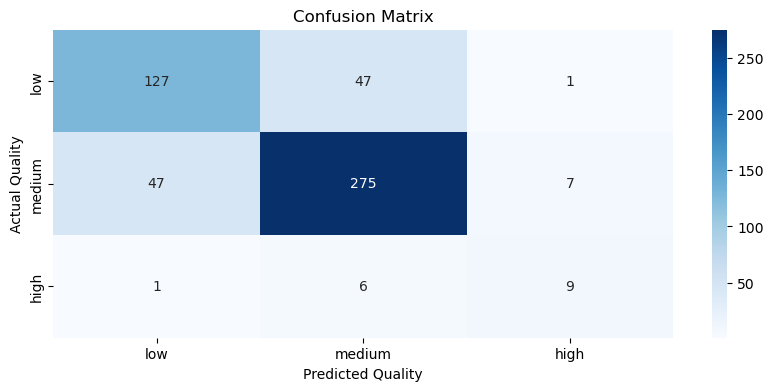

In [ ]:
cm = confusion_matrix(y_test_fold_xgb, xgb_pred)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix')
plt.show()

### Random Forest

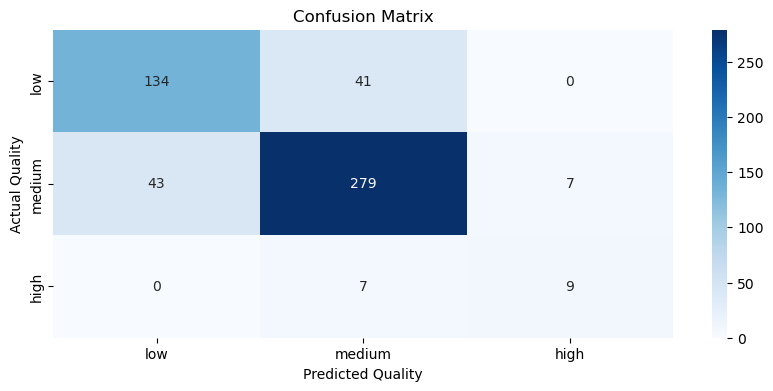

In [ ]:
cm = confusion_matrix(y_test_fold, rf_pred)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=["low","medium","high"], yticklabels=["low","medium","high"])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#TODO - undersampling

# # decision tree  on imbalanced dataset with SMOTE oversampling and random undersampling
# from numpy import mean
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.tree import DecisionTreeClassifier
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# # define dataset
# X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
# 	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# # define pipeline
# model = DecisionTreeClassifier()
# over = SMOTE(sampling_strategy=0.1)
# under = RandomUnderSampler(sampling_strategy=0.5)
# steps = [('over', over), ('under', under), ('model', model)]
# pipeline = Pipeline(steps=steps)
# # evaluate pipeline
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC: %.3f' % mean(scores))

In [ ]:
#TODO - Random forest without filtered data and filtered with z-score